In [51]:
import sys

import gym
import numpy as np
import scipy.integrate as sc_integrate

from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C, DQN

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import sympy as sp
import pickle
import matplotlib.pyplot as plt

## Mathematical system description with SymPy / symbtools

In [6]:
F1, F2 = sp.symbols('F1 F2')

params = sp.symbols('m1, m2, l1, g')
st.make_global(params)
params_values = [(m1, 1.0), (m2, 0.1), (l1, 0.5), (g, 9.81)]

In [7]:
# load model etc. from pickle of flatness analysis notebook
with open("../flatness_notebooks/single_crane_model.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

In [8]:
mod.xx

Matrix([
[   p1],
[   p2],
[   q1],
[pdot1],
[pdot2],
[qdot1]])

In [9]:
mod.calc_state_eq(force_recalculation=True)
mod.eqns

Matrix([
[       m2*pddot1 - tau2*(p1 - q1)/sqrt(p2**2 + (p1 - q1)**2)],
[       g*m2 + m2*pddot2 - p2*tau2/sqrt(p2**2 + (p1 - q1)**2)],
[m1*qddot1 - tau1 + tau2*(p1 - q1)/sqrt(p2**2 + (p1 - q1)**2)]])

In [10]:
states_dot = mod.f + mod.g * sp.Matrix([F1, F2]) ##:

In [11]:
states_dot_wo_params = states_dot.subs(params_values)

In [12]:
states_dot_func = st.expr_to_func([*mod.xx, F1, F2], states_dot_wo_params)

## Gym environment

In [89]:
from abc import abstractmethod
import inspect
import math
from typing import Optional, Union

import numpy as np
from scipy.integrate import solve_ivp

import gym
from gym import logger, spaces
#from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled
#from gym.utils.renderer import Renderer

class StateSpaceModel(gym.Env):
    """ Environment subclass that uses a state space model of the form dx/dt = f(x, u)
    to represent the environments dynamics.

    Args:
        ode
        cost
        x0
        uDim

    Attributes:
        ode (function): ODE for simulation
        cost (function): cost function (returns scalar)
        o
        o_
        oDim
    """

    def __init__(self, ode, cost, x0, uDim, dt,
                 terminal_cost=0.):
        self.tt = [0]
        self.dt = dt
        if callable(x0):
            self.x0 = x0  # initial state
            x0 = x0()
        else:
            x0 = list(x0)
            self.x0 = x0
        self.x = x0  # current state
        self.x_ = x0 # previous state x[k-1]
        self.xDim = len(x0) # state dimension
        self.uDim = uDim # inputs
        self.o = self.x
        self.o_ = self.x_
        self.oDim = len(self.o)  # observation dimensions
        self.ode = ode
        params = inspect.signature(cost).parameters
        cost_args = params.__len__()
        if cost_args == 1:
            self.cost = lambda x_, u_, x, t, mod: cost(x_)
        elif cost_args == 2:
            if 'mod' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, mod)
            elif 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, t)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_)
        elif cost_args == 3:
            if 'mod' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, mod)
            elif 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, t)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x)
        elif cost_args == 4:
            if 'mod' in params and 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, t, mod)
            elif 'mod' in params and not 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x, mod)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x, t)
        elif cost_args == 5:
            self.cost = cost
        else:
            print('Cost function must to be of the form c(x_, u_, x, t, mod), where mod is numpy/sympy.')
            assert(True)
            
        self.terminated = False
        self.terminal_cost = terminal_cost
    
    def get_state(self):
        return self.x

    def reset(self):
        """ Resets environment to state x0

        Args:
            x0 (array, list, callable): initial state

        """
        if callable(self.x0):
            x0 = self.x0()
        self.x_ = x0
        self.x = x0
        self.tt = [0]
        self.terminated = False
        return np.array(self.x, dtype=np.float32)

    def step(self, *args):
        """ Simulates the environment for 1 step of time t.

        Args:
            dt (int, float): duration of step (not solver step size)
            u (array): control/action

        Returns:
            c (float): cost of state transition

        """
        self.x_ = self.x  # shift state (x[k-1] = x[k])
        self.o_ = self.o
        if args.__len__()==2:
            u = args[0]
            dt = args[1]
        elif args.__len__() == 1:
            u = args[0]
            dt = self.dt

        # system simulation
        sol = solve_ivp(lambda t, x: self.ode(t, x, u), (0, dt), self.x_, 'RK45')
        # todo: only output value of the last timestep
        y = list(sol.y[:, -1])  # extract simulation result
        self.x = y
        self.tt.extend([self.tt[-1] + dt])  # increment simulation time
        self.terminated = self.terminate(self.x)
        #x_2pi = mapAngles(self.xIsAngle, self.x_)
        #x2pi = mapAngles(self.xIsAngle, self.x)
        #c = (self.cost(x_2pi, u, x2pi, np) + self.terminal_cost*self.terminated)*dt
        t = self.tt[-1]
        c = (self.cost(self.x_, u, self.x, t, np) + self.terminal_cost * self.terminated) * dt
        
        # todo: place difference for desired value with function or smth here
        self.o =  np.array(self.x, dtype=np.float32)
        reward = -c
        return self.o, reward, self.terminated, {"info": False}
    
    @abstractmethod
    def terminate(self, *args):
        return



class CartPoleEnv(StateSpaceModel):

    metadata = {}

    def __init__(self, cost, x0, dt):
        super(CartPoleEnv, self).__init__(self.ode, cost, x0, 2, dt)

        # define observation space
        high_obs = np.array(
            [
                100.0,
                100.0,
                100.0,
                100.0,
                100.0,
                100.0
            ],
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high_obs, high_obs, dtype=np.float32)
        
        # define action space
        high_act = np.array(
            [ 
                100.0,
                100.0
            ],
            dtype=np.float32,
        )
        self.action_space = spaces.Box(-high_act, high_act, dtype=np.float32)
    
    @staticmethod
    def ode(t, x, u):
        u1 , u2 = u
        u2 = - (m2*g).subs(params_values)
        dxdt = states_dot_func(*x, 0, u2)
        return np.array(dxdt, dtype=np.float32)
    
    def terminate(self, x):
        x1, x2, x3, x4, x5, x6 = x
        if abs(x3) > 20 or abs(x2) > 5 or abs(x1) > 20:
            return True
        else:
            return False

## Cost function, Initial values

In [90]:
mod.xx.T

Matrix([[p1, p2, q1, pdot1, pdot2, qdot1]])

In [91]:
# define the incremental cost
def c_k(x, u):
    x1, x2, x3, x4, x5, x6 = x
    u1, u2 = u
    c = 10*(x2+0.5)**2
    return c

# define the function, that represents the initial value distribution p(x_0)
def p_x0():
    x0 = [
            np.random.uniform(-0.001,0.001), 
            -0.5+np.random.uniform(-0.001,0.001), 
            np.random.uniform(-0.001,0.001), 
            np.random.uniform(-0.001,0.001),
            np.random.uniform(-0.001,0.001),
            np.random.uniform(-0.001,0.001)
    ]
    return x0

t = 10 # time of an episode
dt = 0.05 # time step-size
learning_steps = 1e5 # define training duration

## Create Gym env

In [92]:
# environment without renderings for training
env = CartPoleEnv(c_k, p_x0, dt)

In [93]:
env.reset()
env.step(env.action_space.sample())
env.observation_space
check_env(env)

## Training the model

In [ ]:
%%time
# Learning!
model = A2C('MlpPolicy', env, verbose=1, tensorboard_log="./a2c_cartpole_tensorboard/")
model.learn(total_timesteps=learning_steps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./a2c_cartpole_tensorboard/A2C_17
-------------------------------------
| time/                 |           |
|    fps                | 36        |
|    iterations         | 100       |
|    time_elapsed       | 13        |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -2.83     |
|    explained_variance | 0.818     |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -0.000472 |
|    std                | 0.996     |
|    value_loss         | 2.53e-08  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 37       |
|    iterations         | 200      |
|    time_elapsed       | 26       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -2.84 

## Testing the model

In [71]:
u1_for_plots = []
u2_for_plots = []
x1_for_plots = []
x2_for_plots = []
x3_for_plots = []

obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    u1_for_plots = np.append(u1_for_plots, action[0])
    u2_for_plots = np.append(u2_for_plots, action[1])
    x1_for_plots = np.append(x1_for_plots, obs[0])
    x2_for_plots = np.append(x2_for_plots, obs[1])
    x3_for_plots = np.append(x3_for_plots, obs[2])
    if done:
      obs = env.reset()
      break;

## Plotting

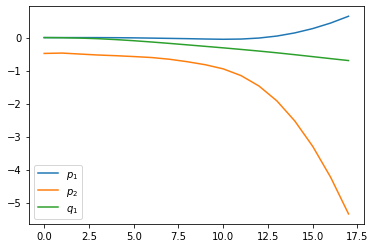

In [72]:
plt.plot(x1_for_plots, label=r"$p_1$")
plt.plot(x2_for_plots, label=r"$p_2$")
plt.plot(x3_for_plots, label=r"$q_1$")
plt.legend()

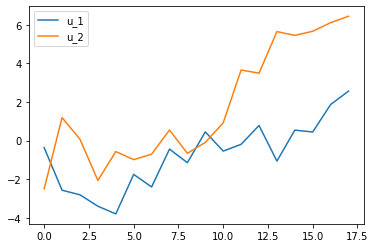

In [73]:
plt.plot(u1_for_plots, label=r"u_1")
plt.plot(u2_for_plots, label=r"u_2")
plt.legend()